# Predict from trained model

## Prepare Dataset
Gerät 'microwave':
 - building 5
 - Von: 2014-06-29 17:23:56+01:00
 - Bis: 2014-11-13 17:55:14+00:00


In [21]:
import nilmtk
import os

building = 5
appliance = 'microwave'
start_time = '2014-10-01'
end_time = '2014-10-02'
sample_period = 10



ukdale = nilmtk.DataSet("ukdale2.h5")

mains = ukdale.buildings[building].elec.mains().power_series_all_data(sample_period=sample_period, resample_kwargs={'label': 'right'})



In [42]:
import numpy as np

def pre_process_input(data, window_size):
    half_window = window_size // 2
    data = np.array(data).reshape(-1, 1)
    data_processed = np.zeros((len(data) - window_size + 1, window_size, 1)) # Hinzufügen einer Dimension
    for i in range(len(data) - window_size + 1):
        data_processed[i] = data[i:i + window_size]
    return data_processed


window_size = 99 # ist im seq2point.py der wert sequence_lenght (default)
test_data_processed = pre_process_input(mains, window_size)


In [54]:
from tensorflow.keras.models import load_model

model_path = os.path.join(f'models/seq2point-temp-weights-{appliance}-epoch0.h5')
model = load_model(model_path)

predictions = model.predict(test_data_processed)
# predictions_inverse_scaled = scaler.inverse_transform(predictions)
predictions


array([[-5.3413124],
       [-7.670416 ],
       [-6.4395814],
       ...,
       [-4.1062517],
       [-4.2157965],
       [-4.3273697]], dtype=float32)

Disaggregierten Leistungswerte (in Watt) für das gewählte Gerät (in diesem Fall die Mikrowelle) über den gesamten Testzeitraum. 
Jeder Wert im Array entspricht einer Vorhersage der Leistungsaufnahme der Mikrowelle zu einem bestimmten Zeitpunkt.

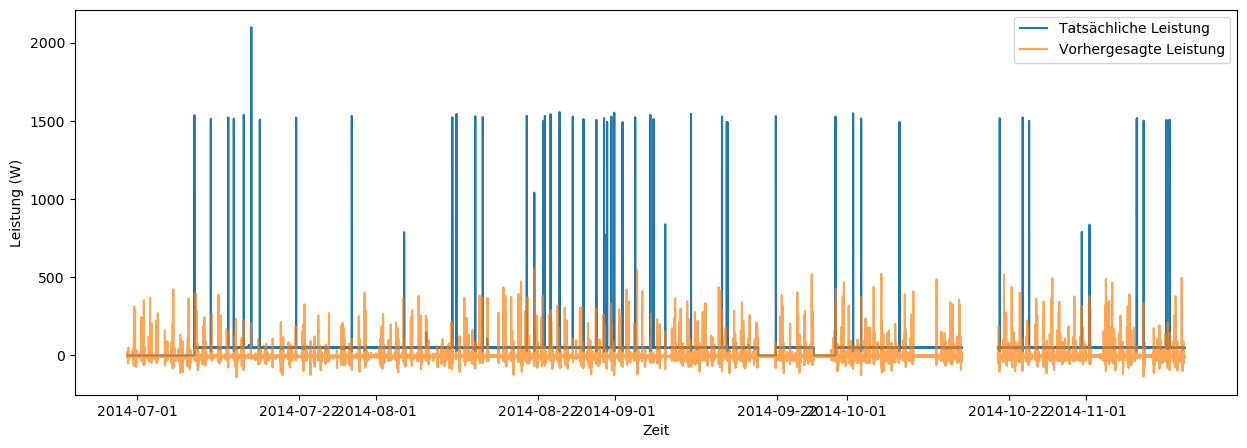

In [56]:
import matplotlib.pyplot as plt
pred = predictions

# groundtruth der Mikrowelle
appliance_data = ukdale.buildings[building].elec[appliance].power_series_all_data(sample_period=sample_period, resample_kwargs={'label': 'right'})

pred = pred.reshape(-1) # oder predictions.flatten()
# predictions = predictions.flatten()

# Leistungswerte zuschneiden
appliance_data = appliance_data.iloc[:len(pred)]
predictions = predictions[:len(appliance_data)]

# Visualisieren von pred und groundtruth
plt.figure(figsize=(15, 5))
plt.plot(appliance_data, label="Tatsächliche Leistung")
plt.plot(appliance_data.index, predictions, label="Vorhergesagte Leistung", alpha=0.7)
plt.xlabel("Zeit")
plt.ylabel("Leistung (W)")
plt.legend()
plt.show()